<a href="https://colab.research.google.com/github/NR55/StockPredictorUsingStacking/blob/main/MidSem1_FML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 5.6 MB/s eta 0:00:00


In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00


In [164]:
import yfinance as yf
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import StackingForecaster
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.ets import AutoETS
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [189]:
# Fetch stock data
def fetch_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)
    stock = stock.asfreq('D').ffill()
    return stock

# Load data
ticker = "AAPL"  # Change this to your preferred stock symbol
start_date = "2020-01-01"
end_date = "2024-01-01"
data = fetch_stock_data(ticker, start_date, end_date)

features = ["Open", "High", "Low", "Volume_scaled", "Close"]

[*********************100%***********************]  1 of 1 completed


In [190]:
num_days = 30

In [191]:
scaler = MinMaxScaler()
data["Volume_scaled"] = scaler.fit_transform(data[["Volume"]])

# Create the 7th lag for all feature columns
for col in features:
      data[f"lag_{col}"] = data[col].shift(1)

# Add current day's Open price as an additional feature
data["Open_today"] = data["Open"]

# Drop NaN values caused by shifting
data.dropna(inplace=True)

# Define target as the current day's Close price
target = data["Close"]

exog_cols = ["Open_today"]
exog = data[exog_cols]

for col in features:
    exog[f"lag_{col}"] = data[f"lag_{col}"]

# Split data into train and test sets
y_train, y_test, X_train, X_test = temporal_train_test_split(y=target, X=exog, test_size=0.2)


<ipython-input-191-454f02d8c1dc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog[f"lag_{col}"] = data[f"lag_{col}"]
<ipython-input-191-454f02d8c1dc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog[f"lag_{col}"] = data[f"lag_{col}"]
<ipython-input-191-454f02d8c1dc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [192]:
pd.concat([exog, target], axis=1)

,"(Open_today, )","(lag_Open, )","(lag_High, )","(lag_Low, )","(lag_Volume_scaled, )","(lag_Close, )",AAPL
Date,,,,,,,
2020-01-03,71.941343,71.721019,72.776598,71.466812,0.276876,72.716072,72.009132
2020-01-04,71.941343,71.941343,72.771760,71.783977,0.303816,72.009132,72.009132
2020-01-05,71.941343,71.941343,72.771760,71.783977,0.303816,72.009132,72.009132
2020-01-06,71.127881,71.941343,72.771760,71.783977,0.303816,72.009132,72.582924
2020-01-07,72.592586,71.127881,72.621661,70.876090,0.234405,72.582924,72.241539
...,...,...,...,...,...,...,...
2023-12-25,194.015153,194.015153,194.243791,191.818350,0.032486,192.444595,192.444595
2023-12-26,192.454528,194.015153,194.243791,191.818350,0.032486,192.444595,191.897873
2023-12-27,191.341204,192.454528,192.732856,191.679185,0.012103,191.897873,191.997253


In [193]:
base_models = [
    ('1', AutoARIMA(sp=7, suppress_warnings=True)),  # AutoARIMA with seasonality
    ('2', make_reduction(KNeighborsRegressor(3), window_length=30, strategy="recursive")),
    ('3', STLForecaster(sp=7)),
    ('4', AutoETS(auto=True))
]

# ('3', make_reduction(LinearRegression(), window_length=30, strategy="recursive")),  # Linear Regression
# ('4', make_reduction(RandomForestRegressor(n_estimators=100, random_state=42), window_length=30, strategy="recursive")),  # Random Forest
# ('5', make_reduction(XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"), window_length=30, strategy="recursive")),  # XGBoost
# ('6', make_reduction(GaussianNB(), window_length=30, strategy="recursive")),  # Naïve Bayes

# Define meta-model
meta_model = LinearRegression()

# Create stacking ensemble
model = StackingForecaster(base_models,meta_model)
fh = np.arange(1, num_days+1)
model.fit(y_train, X_train, fh)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

StackingForecaster(forecasters=[('1', AutoARIMA(sp=7, suppress_warnings=True)),
                                ('2',
                                 RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=3),
                                                                      window_length=30)),
                                ('3', STLForecaster(sp=7)),
                                ('4', AutoETS(auto=True))],
                   regressor=LinearRegression())

In [194]:
def evaluate(X_test, y_test, y_pred):
    trend = pd.DataFrame()

    # Calculate actual and predicted trends
    trend['Actual'] = y_test.squeeze() - X_test["Open_today"]
    # trend['Predicted'] = y_pred - X_test["Open_today"]
    trend['Predicted'] = y_pred.squeeze() - X_test["Open_today"]

    # Convert to boolean: True if price increased, False if it decreased
    trend['Actual_Trend'] = trend['Actual'] > 0
    trend['Predicted_Trend'] = trend['Predicted'] > 0

    # accuracy = (trend['Actual_Trend'] == trend['Predicted_Trend']).mean()
    tn, fp, fn, tp = confusion_matrix(trend['Actual_Trend'], trend['Predicted_Trend']).ravel()

    # Compute classification metrics
    accuracy = accuracy_score(trend['Actual_Trend'], trend['Predicted_Trend'])
    precision = precision_score(trend['Actual_Trend'], trend['Predicted_Trend'])
    recall = recall_score(trend['Actual_Trend'], trend['Predicted_Trend'])
    f1 = f1_score(trend['Actual_Trend'], trend['Predicted_Trend'])

    # Print results
    print(f"Confusion Matrix:\nTP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

    print(f"Trend Prediction Accuracy: {accuracy:.2%}")
    return accuracy, trend


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Confusion Matrix:
TP: 8, FP: 1, FN: 13, TN: 8
Accuracy: 53.33%
Precision: 88.89%
Recall: 38.10%
F1 Score: 53.33%
Trend Prediction Accuracy: 53.33%


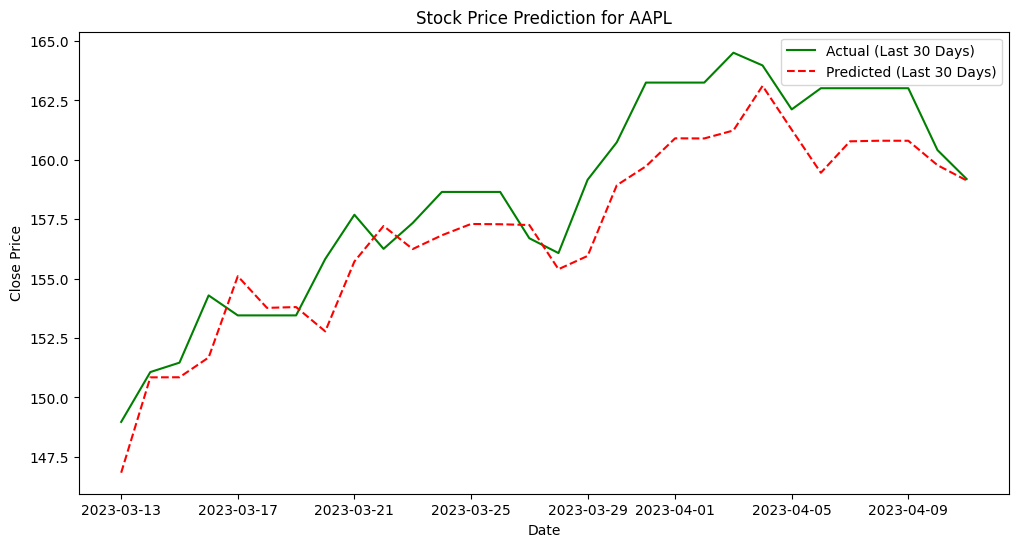

In [196]:
y_pred = model.predict(fh, X_test[:num_days])

# mape = mean_absolute_percentage_error(y_test[:num_days], y_pred)
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

# mape = mean_absolute_percentage_error(y_test[:num_days], exog["Open_today"][:num_days])
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

evaluate(X_test[:num_days], y_test[:num_days], y_pred)
pred_ind = y_test[:num_days].index
actual_last_days = y_test[:num_days]

plt.figure(figsize=(12, 6))
plt.plot(actual_last_days.index, actual_last_days, label=f"Actual (Last {num_days} Days)", color="green")
# plt.plot(pred_ind, exog["Open_today"][:num_days], label=f"Open Today (Last {num_days} Days)", color="blue", linestyle="dashed")
plt.plot(pred_ind, y_pred, label=f"Predicted (Last {num_days} Days)", color="red", linestyle="dashed")

plt.legend()
plt.title(f"Stock Price Prediction for {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()
